In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Editing with Imagen 2 and MaskMode on Vertex AI

Adapted from: [Editing with Imagen 2 and MaskMode on Vertex AI](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/image_editing_maskmode.ipynb)

Author(s): [Jorj Ismailyan](https://github.com/jismailyan-google), Shuai Tang

Modified by: [Wan Qi Ang](https://github.com/angwanqi) for 2024 EDB x Google Cloud - Cloud AI Take Off Program

Last updated: 30 October 2024

## Overview

[Imagen 2 on Vertex AI](https://cloud.google.com/vertex-ai/docs/generative-ai/image/overview) brings Google's state of the art generative AI capabilities to application developers. With Imagen 2 on Vertex AI, application developers can build next-generation AI products that edit images.

With Imagen 2, you cannot only generate an image, but edit an image by setting a MaskMode in the request.

This notebook focuses on **image editing with MaskMode** only. Learn more about [editing with the Imagen](https://cloud.google.com/vertex-ai/generative-ai/docs/image/edit-images).


### Objectives

In this notebook, you will be exploring the image editing features of Imagen using the Vertex AI Python SDK. You will

- Edit an image with a text prompt and mask mode.
- Insert an object into an image.
- Remove an object from an image.
- Pad and outpaint an image.
- Generate new backgrounds for images.


### Costs

- This notebook uses billable components of Google Cloud:
  - Vertex AI (Imagen)

- Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Install Vertex AI SDK for Python

In [ ]:
%pip install --quiet --upgrade --user google-cloud-aiplatform
%pip install --quiet opencv-python

### Restart current runtime
To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.
<div class="alert alert-block alert-success"> 
<b>NOTE:</b> Only restart the current runtime if you installed libraries. If you did not install new libraries, you do not need to restart the kernel.
</div>

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

After the restart is complete, continue to the next step.


<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Import libraries and define utility functions

In [ ]:
import io
import math
from typing import Any

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

import vertexai
from vertexai.preview.vision_models import Image as Vertex_Image
from vertexai.preview.vision_models import ImageGenerationModel, ImageGenerationResponse

In [ ]:
# Gets the image bytes from a PIL Image object.
def get_bytes_from_pil(image: Image) -> bytes:
    byte_io_png = io.BytesIO()
    image.save(byte_io_png, "PNG")
    return byte_io_png.getvalue()


# Corrects the orientation of an image if needed.
def maybe_rotate(img_pil):
    exif = img_pil.getexif()
    rotation = exif.get(274)

    if rotation == 3:
        img_pil = img_pil.rotate(180, expand=True)
    elif rotation == 6:
        img_pil = img_pil.rotate(270, expand=True)
    elif rotation == 8:
        img_pil = img_pil.rotate(90, expand=True)
    return img_pil


# Extract bounding boxes from a mask.
def get_bbox_from_mask(mask_image: np.ndarray, box_area_thres: int = 50) -> np.ndarray:
    """Finds the contours from a mask image."""
    contours, _ = cv.findContours(mask_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    bboxes = np.zeros((len(contours), 4))
    for i, contour in enumerate(contours):
        x, y, w, h = cv.boundingRect(contour)
        bboxes[i] = (x, y, x + w, y + h)
    bboxes = filter(lambda x: (x[2] - x[0]) * (x[3] - x[1]) > box_area_thres, bboxes)
    bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
    return bboxes


# Edits specific areas and pastes them back into the original image.
def crop_insert_paste(
    generation_model: ImageGenerationModel,
    image: Image,
    mask: Image,
    boxes: np.array,
    pad_ratio: int,
    prompt: str,
    neg_prompt: str,
    seed: int = 0,
    mask_dilation: float = 0.01,
    guidance_scale: int = 60,
    samples: int = 4,
):
    generated_imgs = [image.copy() for _ in range(samples)]
    for box in boxes:
        # Calculate cropping area with padding.
        box_w_pad = pad_ratio * (box[2] - box[0])
        box_h_pad = pad_ratio * (box[3] - box[1])
        x1 = np.round(np.clip(box[0] - box_w_pad, 0, image.width)).astype("int")
        x2 = np.round(np.clip(box[2] + box_w_pad, 0, image.width)).astype("int")
        y1 = np.round(np.clip(box[1] - box_h_pad, 0, image.height)).astype("int")
        y2 = np.round(np.clip(box[3] + box_h_pad, 0, image.height)).astype("int")

        im_crop = image.crop([x1, y1, x2, y2])
        mask_crop = mask.crop([x1, y1, x2, y2])
        image_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(im_crop))
        mask_vertex = Vertex_Image(image_bytes=get_bytes_from_pil(mask_crop))

        # Edit the cropped area of the image.
        generated_crops = generation_model.edit_image(
            prompt=prompt,
            negative_prompt=neg_prompt,
            base_image=image_vertex,
            mask=mask_vertex,
            number_of_images=samples,
            edit_mode="inpainting-insert",
            seed=seed,
            guidance_scale=guidance_scale,
            mask_dilation=mask_dilation,
        )

        # Paste the generated edits of the cropped area into the corresponding
        # positions in the base image.
        for i, crop in enumerate(generated_crops.images):
            generated_imgs[i].paste(crop._pil_image, (x1, y1))
    return generated_imgs


# Pads an image for outpainting. Provides options to control the positioning of
# the original image.
def pad_to_target_size(
    source_image,
    target_size=(1536, 1536),
    mode="RGB",
    vertical_offset_ratio=0,
    horizontal_offset_ratio=0,
    fill_val=255,
):
    orig_image_size_w, orig_image_size_h = source_image.size
    target_size_w, target_size_h = target_size

    insert_pt_x = (target_size_w - orig_image_size_w) // 2 + int(
        horizontal_offset_ratio * target_size_w
    )
    insert_pt_y = (target_size_h - orig_image_size_h) // 2 + int(
        vertical_offset_ratio * target_size_h
    )
    insert_pt_x = min(insert_pt_x, target_size_w - orig_image_size_w)
    insert_pt_y = min(insert_pt_y, target_size_h - orig_image_size_h)

    if mode == "RGB":
        source_image_padded = Image.new(
            mode, target_size, color=(fill_val, fill_val, fill_val)
        )
    elif mode == "L":
        source_image_padded = Image.new(mode, target_size, color=(fill_val))
    else:
        raise ValueError("source image mode must be RGB or L.")

    source_image_padded.paste(source_image, (insert_pt_x, insert_pt_y))
    return source_image_padded


# Pads and resizes image and mask to the same target size.
def pad_image_and_mask(
    image_vertex: Vertex_Image,
    mask_vertex: Vertex_Image,
    target_size,
    vertical_offset_ratio,
    horizontal_offset_ratio,
    viz=True,
):
    image_vertex.thumbnail(target_size)
    mask_vertex.thumbnail(target_size)

    image_vertex = pad_to_target_size(
        image_vertex,
        target_size=target_size,
        mode="RGB",
        vertical_offset_ratio=vertical_offset_ratio,
        horizontal_offset_ratio=horizontal_offset_ratio,
        fill_val=0,
    )
    mask_vertex = pad_to_target_size(
        mask_vertex,
        target_size=target_size,
        mode="L",
        vertical_offset_ratio=vertical_offset_ratio,
        horizontal_offset_ratio=horizontal_offset_ratio,
        fill_val=255,
    )
    if viz:
        print(
            f"image size(with x height): {image_vertex.size[0]} x {image_vertex.size[1]}"
        )
        plt.axis("off")
        plt.imshow(image_vertex)
        plt.imshow(mask_vertex, alpha=0.3)
        plt.title("Padded image and mask overlay")
    return image_vertex, mask_vertex


# Displays images in a grid below the cell
def display_images_in_grid(images: list[Any]) -> None:
    """Displays the provided images in a grid format. 4 images per row.

    Args:
        images: A list of images to display.
    """

    # Determine the number of rows and columns for the grid layout.
    nrows: int = math.ceil(len(images) / 5)  # Display at most 4 images per row
    ncols: int = min(len(images) + 1, 5)  # Adjust columns based on the number of images

    # Create a figure and axes for the grid layout.
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Display the image in the current axis.
            if hasattr(images[i], "_pil_image"):
                image = images[i]._pil_image
            else:
                image = images[i]
            ax.imshow(image)

            # Adjust the axis aspect ratio to maintain image proportions.
            ax.set_aspect("equal")

            # Disable axis ticks for a cleaner appearance.
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # Hide empty subplots to avoid displaying blank axes.
            ax.axis("off")

    # Adjust the layout to minimize whitespace between subplots.
    plt.tight_layout()

    # Display the figure with the arranged images.
    plt.show()

# Generate image based on input prompt
def generate_image(prompt):
    response = generation_model.generate_images(prompt=prompt,)
    generated_img = response.images[0]
    return generated_img

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and enable the Vertex AI API.

Learn more about setting up a project and a development environment.

In [ ]:
# Retrieve and set the Project ID
PROJECT_ID= !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

# Set the default region for launching jobs.
REGION = 'us-central1'

print(f"Project ID:", PROJECT_ID)
print(f"Project Region:", REGION)

# Initialize Vertex AI with Project ID and Region
vertexai.init(project=PROJECT_ID, location=REGION)

### Load the image generation model

Imagen 2: `imagegeneration@006`

In [ ]:
IMAGE_GENERATION_MODEL = "imagegeneration@006"
generation_model = ImageGenerationModel.from_pretrained(IMAGE_GENERATION_MODEL)

## Select an image to edit

## Edit images using MaskMode

Now you can edit images without providing your own mask. Configure the `mask_mode` field `edit_image` request to automatically generate a mask on the input image.

MaskMode provides the following modes:
* **Background**: Edit the background of an image
* **Foreground**: Edit the foreground of an image
* **Semantic**: Edit specified objects in an image. You can edit 1 to 5 objects in an image using semantic segmentation classes.

The `semantic` maskMode option requires you to set **Segmentation classes**. You must set 1 to 5 classes using the desired class ID. The full table of available classes is listed in the `Appendix` section at the end of this notebook.

### Explore different MaskMode options

This section will explores how to edit images using different `edit_mode` and `mask_mode` parameter options.

### Inpainting-insert with Background maskMode

Edit the background of an image using a text prompt.

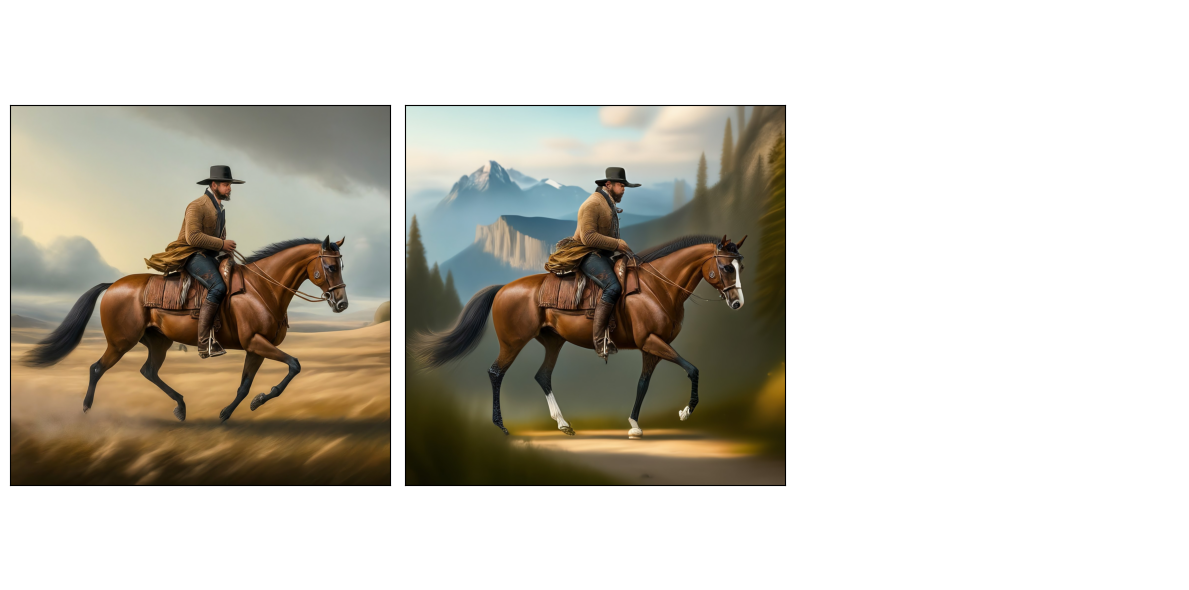

In [17]:
classes = None
EDIT_MODE = "inpainting-insert"
MASK_MODE = "background"

# Generate an image
PROMPT = "A man riding a horse in plain lands in motion"
INPUT_IMAGE = generate_image(PROMPT)

# The background will be edited to adhere to the text prompt below.
PROMPT = "forested woodland, mountains in the distance"
# [Optional] Set a negative prompt to define what you don't want to see.
NEGATIVE_PROMPT = "leaves on the ground"

response: ImageGenerationResponse = generation_model.edit_image(
    prompt=PROMPT,
    base_image=INPUT_IMAGE,
    negative_prompt=NEGATIVE_PROMPT,
    edit_mode=EDIT_MODE,
    mask_mode=MASK_MODE,
    segmentation_classes=classes,
)

# Display the unedited base image and the edited images
images = [INPUT_IMAGE]
images.extend(response.images)
display_images_in_grid(images)

### Inpainting-insert with Foreground maskMode

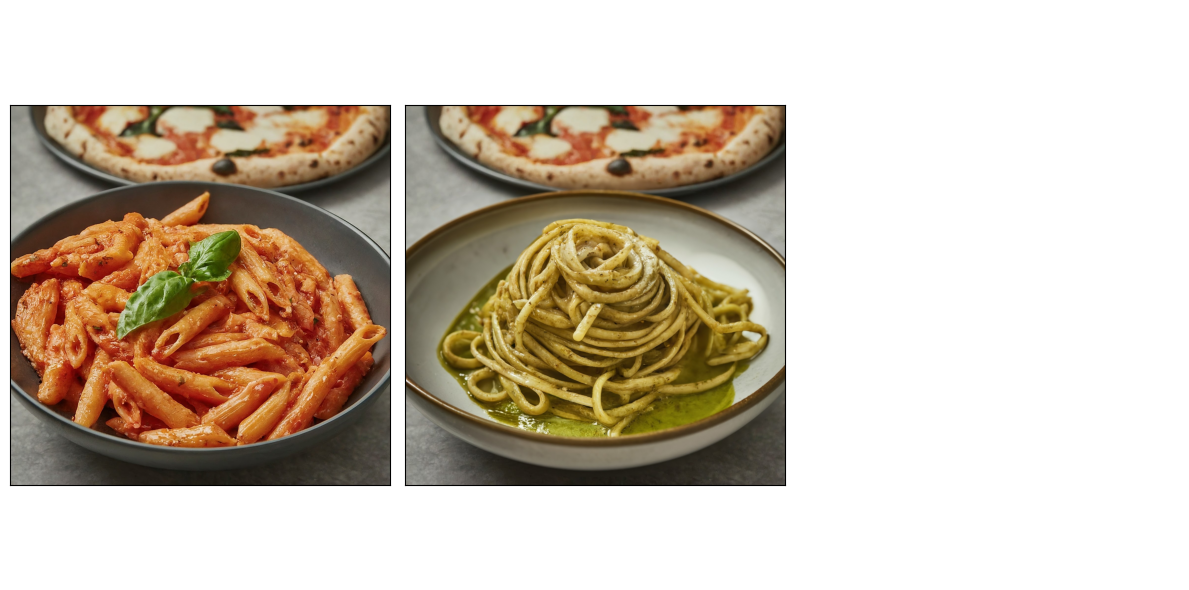

In [18]:
EDIT_MODE = "inpainting-insert"
MASK_MODE = "foreground"

# Generate an image
PROMPT = "A plate of tomato penne pasta in the foreground and a pizza in the background on a dining table. Both dishes must be in full view"
INPUT_IMAGE = generate_image(PROMPT)

# The foreground of the object will be edited according to the text prompt below.
PROMPT = "Pesto linguine"
# [Optional] Set a negative prompt to define what you don't want to see.
NEGATIVE_PROMPT = ""

response: ImageGenerationResponse = generation_model.edit_image(
    prompt=PROMPT,
    base_image=INPUT_IMAGE,
    negative_prompt=NEGATIVE_PROMPT,
    edit_mode=EDIT_MODE,
    mask_mode=MASK_MODE,
    segmentation_classes=classes,
)

# Display the unedited base image and the edited images
images = [INPUT_IMAGE]
images.extend(response.images)
display_images_in_grid(images)

### Inpainting-insert with Semantic maskMode

Edit a specified object or multiple objects in an image using Semantic maskMode.
You must set between 1 and 5 IDs in the `segmentation_classes` field. The full
list of available segmentation classes is listed in the Appendix section at the end of this notebook.

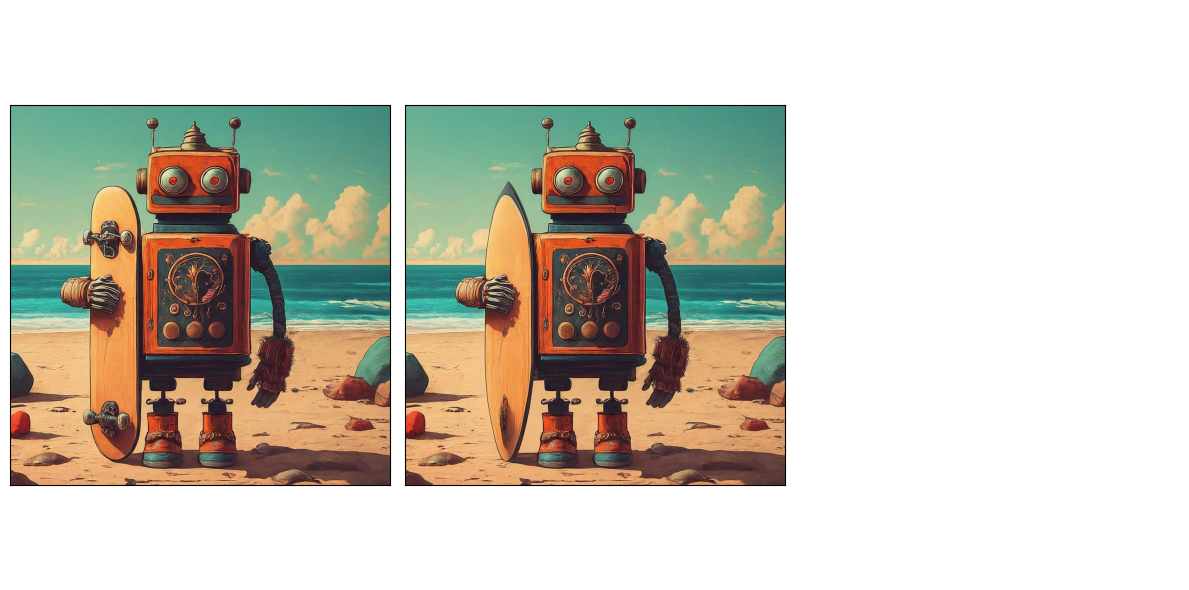

In [26]:
EDIT_MODE = "inpainting-insert"
MASK_MODE = "semantic"

# Generate an image
PROMPT = "A vintage-style robot on a beach holding a skateboard, facing the camera. Retro cartoon aesthetic."
INPUT_IMAGE = generate_image(PROMPT)

# Set the specified object(s) to edit in an image using a segmentation class.
SEGMENTATION_CLASS = 156  # #skateboard

PROMPT = "surfboard"
# [Optional] Set a negative prompt to define what you don't want to see.
NEGATIVE_PROMPT = ""

response: ImageGenerationResponse = generation_model.edit_image(
    prompt=PROMPT,
    base_image=INPUT_IMAGE,
    negative_prompt=NEGATIVE_PROMPT,
    edit_mode=EDIT_MODE,
    mask_mode=MASK_MODE,
    segmentation_classes=[SEGMENTATION_CLASS],
)

# Display the unedited base image and the edited images
images = [INPUT_IMAGE]
images.extend(response.images)
display_images_in_grid(images)

### Inpainting-remove with foreground maskMode

Remove the foreground object of an image.

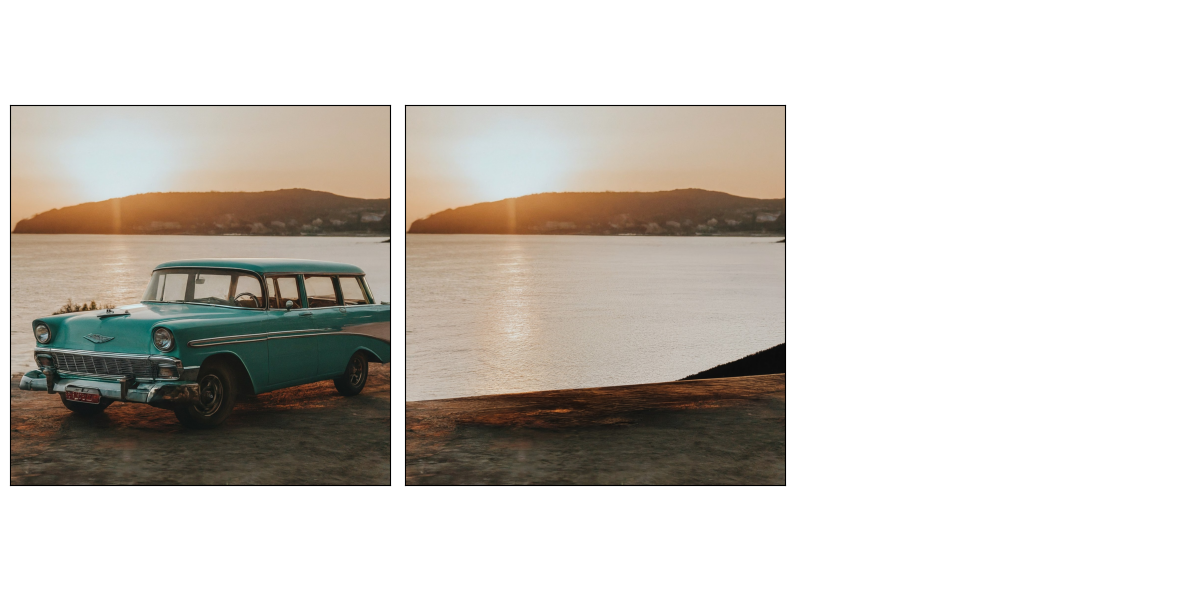

In [16]:
EDIT_MODE = "inpainting-remove"
MASK_MODE = "foreground"

# Generate an image
PROMPT = "A retro car parked at the beach"
INPUT_IMAGE = generate_image(PROMPT)

PROMPT = "Background, landscape photo"
# [Optional] Set a negative prompt to define what you don't want to see.
NEGATIVE_PROMPT = ""

response: ImageGenerationResponse = generation_model.edit_image(
    prompt=PROMPT,
    base_image=INPUT_IMAGE,
    edit_mode=EDIT_MODE,
    mask_mode=MASK_MODE,
    segmentation_classes=[],
)

# Display the unedited base image and the edited images
images = [INPUT_IMAGE]
images.extend(response.images)
display_images_in_grid(images)

### Inpainting-remove with Semantic maskMode

Remove the specified object(s) in an image using a segmentation class.

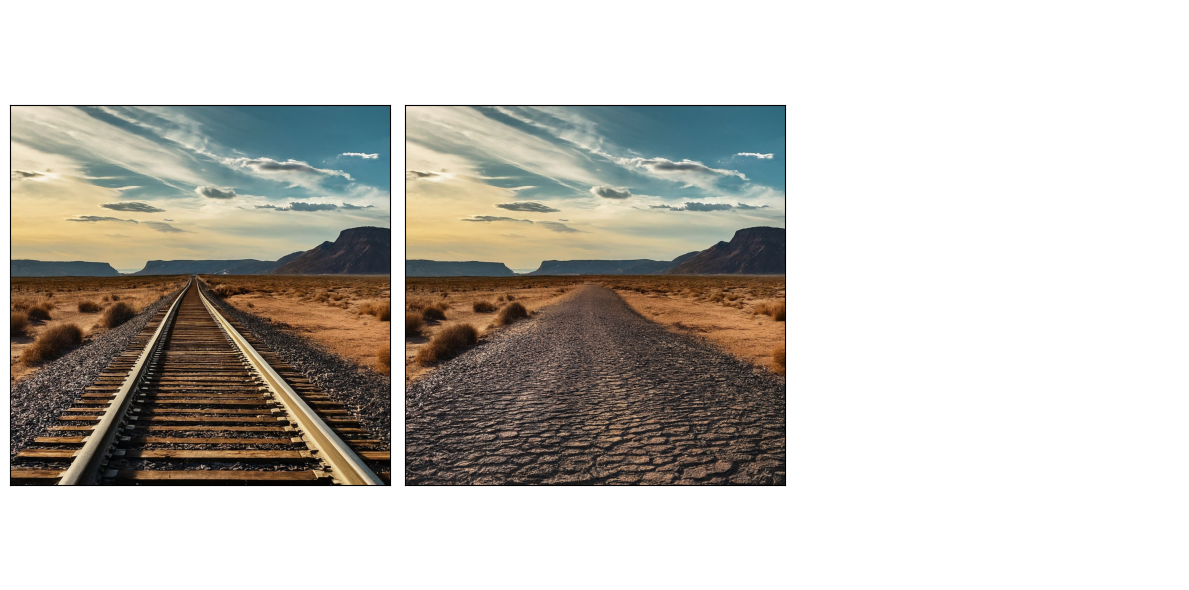

In [50]:
EDIT_MODE = "inpainting-remove"
MASK_MODE = "semantic"

# Generate an image
PROMPT = "Railroad tracks disappearing into a desert landscape"

response: ImageGenerationResponse = generation_model.generate_images(
    prompt=PROMPT,
)

INPUT_IMAGE = response.images[0]

# Set the object that will be removed according to its segmentation class ID.
SEGMENTATION_CLASS = 97

# Set a text prompt to guide the edited image.
PROMPT = "Background, landscape photo"
# Set a negative prompt to define what you don't want to see.
NEGATIVE_PROMPT = ""

response: ImageGenerationResponse = generation_model.edit_image(
    prompt=PROMPT,
    base_image=INPUT_IMAGE,
    negative_prompt=NEGATIVE_PROMPT,
    edit_mode=EDIT_MODE,
    mask_mode=MASK_MODE,
    segmentation_classes=[SEGMENTATION_CLASS],
)

# Display the input image and the edited images
images = [INPUT_IMAGE]
images.extend(response.images)
display_images_in_grid(images)

## Conclusion

You have explored the Imagen's image editing features through the Vertex AI Python SDK, including the additional parameters that influence image generation.

Check out the Vertex AI reference to learn more about how to [Edit image prompts](https://cloud.google.com/vertex-ai/generative-ai/docs/image/img-gen-prompt-guide#edit-prompts).

## Appendix

### Semantic segmentation classes

| Class ID | Instance Type | Class ID | Instance Type | Class ID | Instance Type | Class ID | Instance Type |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 0 | backpack | 50 | carrot | 100 | sidewalk_pavement | 150 | skis |
| 1 | umbrella | 51 | hot_dog | 101 | runway | 151 | snowboard |
| 2 | bag | 52 | pizza | 102 | terrain | 152 | sports_ball |
| 3 | tie | 53 | donut | 103 | book | 153 | kite |
| 4 | suitcase | 54 | cake | 104 | box | 154 | baseball_bat |
| 5 | case | 55 | fruit_other | 105 | clock | 155 | baseball_glove |
| 6 | bird | 56 | food_other | 106 | vase | 156 | skateboard |
| 7 | cat | 57 | chair_other | 107 | scissors | 157 | surfboard |
| 8 | dog | 58 | armchair | 108 | plaything_other | 158 | tennis_racket |
| 9 | horse | 59 | swivel_chair | 109 | teddy_bear | 159 | net |
| 10 | sheep | 60 | stool | 110 | hair_dryer | 160 | base |
| 11 | cow | 61 | seat | 111 | toothbrush | 161 | sculpture |
| 12 | elephant | 62 | couch | 112 | painting | 162 | column |
| 13 | bear | 63 | trash_can | 113 | poster | 163 | fountain |
| 14 | zebra | 64 | potted_plant | 114 | bulletin_board | 164 | awning |
| 15 | giraffe | 65 | nightstand | 115 | bottle | 165 | apparel |
| 16 | animal_other | 66 | bed | 116 | cup | 166 | banner |
| 17 | microwave | 67 | table | 117 | wine_glass | 167 | flag |
| 18 | radiator | 68 | pool_table | 118 | knife | 168 | blanket |
| 19 | oven | 69 | barrel | 119 | fork | 169 | curtain_other |
| 20 | toaster | 70 | desk | 120 | spoon | 170 | shower_curtain |
| 21 | storage_tank | 71 | ottoman | 121 | bowl | 171 | pillow |
| 22 | conveyor_belt | 72 | wardrobe | 122 | tray | 172 | towel |
| 23 | sink | 73 | crib | 123 | range_hood | 173 | rug_floormat |
| 24 | refrigerator | 74 | basket | 124 | plate | 174 | vegetation |
| 25 | washer_dryer | 75 | chest_of_drawers | 125 | person | 175 | bicycle |
| 26 | fan | 76 | bookshelf | 126 | rider_other | 176 | car |
| 27 | dishwasher | 77 | counter_other | 127 | bicyclist | 177 | autorickshaw |
| 28 | toilet | 78 | bathroom_counter | 128 | motorcyclist | 178 | motorcycle |
| 29 | bathtub | 79 | kitchen_island | 129 | paper | 179 | airplane |
| 30 | shower | 80 | door | 130 | streetlight | 180 | bus |
| 31 | tunnel | 81 | light_other | 131 | road_barrier | 181 | train |
| 32 | bridge | 82 | lamp | 132 | mailbox | 182 | truck |
| 33 | pier_wharf | 83 | sconce | 133 | cctv_camera | 183 | trailer |
| 34 | tent | 84 | chandelier | 134 | junction_box | 184 | boat_ship |
| 35 | building | 85 | mirror | 135 | traffic_sign | 185 | slow_wheeled_object |
| 36 | ceiling | 86 | whiteboard | 136 | traffic_light | 186 | river_lake |
| 37 | laptop | 87 | shelf | 137 | fire_hydrant | 187 | sea |
| 38 | keyboard | 88 | stairs | 138 | parking_meter | 188 | water_other |
| 39 | mouse | 89 | escalator | 139 | bench | 189 | swimming_pool |
| 40 | remote | 90 | cabinet | 140 | bike_rack | 190 | waterfall |
| 41 | cell phone | 91 | fireplace | 141 | billboard | 191 | wall |
| 42 | television | 92 | stove | 142 | sky | 192 | window |
| 43 | floor | 93 | arcade_machine | 143 | pole | 193 | window_blind |
| 44 | stage | 94 | gravel | 144 | fence | | |
| 45 | banana | 95 | platform | 145 | railing_banister | | |
| 46 | apple | 96 | playingfield | 146 | guard_rail | | |
| 47 | sandwich | 97 | railroad | 147 | mountain_hill | | |
| 48 | orange | 98 | road | 148 | rock | | |
| 49 | broccoli | 99 | snow | 149 | frisbee | | |
